In [1]:
import pandas as pd
import numpy as np
import time
import os.path as path
from ast import literal_eval
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

/Users/sijiazong/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Prepare datasets(user_item_ratings, game_metadata, game_id_name_pairs)

- User item ratings

In [3]:
user_item_df = pd.read_csv("../processed_data/ratings.csv")

In [4]:
print("There are {} unique users and {} unique items in user item ratings".format(user_item_df.user_id.nunique(), user_item_df.item_id.nunique()))

There are 70329 unique users and 10974 unique items in user item ratings


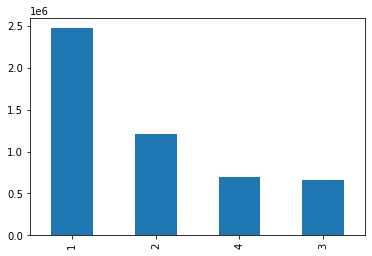

In [5]:
pd.value_counts(user_item_df['rating']).plot(kind="bar")

- Games Metadata

In [6]:
games = pd.read_csv("../processed_data/games_metadata.csv")

- All game id/name pair in both metadata/useritem pair

In [7]:
all_games = pd.read_csv("../processed_data/all_games_id_name_pair.csv")

## Building functions to generate item features data

In [8]:
# view list of features for consideration
# Unique values for features
# price_category: 4
# price: 145
# specs: 40
# genres: 22
# tags: 339
# genres + specs: 62(genres and specs are uniquely different)
# genres + tags: 342(a lot of tags are in genres)
# release_year: 43
# bundles: 567
games[['publisher', 'developer', 'genres', 'tags', 'specs', 'bundles', 'price_category', 'price', 'release_year']]

,publisher,developer,genres,tags,specs,bundles,price_category,price,release_year
0,Kotoshiro,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],NaN,Low,4.99,2018.0
1,"Making Fun, Inc.",Secret Level SRL,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",NaN,Free,0.00,2018.0
2,Poolians.com,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",NaN,Free,0.00,2017.0
3,彼岸领域,彼岸领域,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']",['Single-player'],NaN,Low,0.99,2017.0
4,NaN,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",NaN,Low,2.99,NaN
...,...,...,...,...,...,...,...,...,...
32126,Ghost_RUS Games,"Nikita ""Ghost_RUS""","['Casual', 'Indie', 'Simulation', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation']","['Single-player', 'Steam Achievements']",NaN,Low,1.99,2018.0
32127,Sacada,Sacada,"['Casual', 'Indie', 'Strategy']","['Strategy', 'Indie', 'Casual']","['Single-player', 'Steam Achievements', 'Steam...",NaN,Low,4.99,2018.0
32128,Laush Studio,Laush Dmitriy Sergeevich,"['Indie', 'Racing', 'Simulation']","['Indie', 'Simulation', 'Racing']","['Single-player', 'Steam Achievements', 'Steam...",NaN,Low,1.99,2018.0
32129,SIXNAILS,"xropi,stev3ns","['Casual', 'Indie']","['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","['Single-player', 'Steam Achievements', 'Steam...",NaN,Low,4.99,2017.0


In [9]:
def build_game_features_list(item_features_cols):
    total_features = set()
    game_features_list = []
    for row in games.itertuples(index=False):
        features = set()
        for col in item_features_cols:
            val = getattr(row, col)
            if pd.isnull(val):
                continue
            if col in {"genres", "tags", "specs", "bundles"}:
                features.update(literal_eval(val))
            else:
                features.add(val)
        game_features_list.append(list(features))
        total_features.update(features)
    return game_features_list, list(total_features)

In [10]:
def getGameFeaturesData(item_features_cols):
    game_features_list, total_features = build_game_features_list(item_features_cols)
    game_tuple = list(zip(games.id, game_features_list))
    return (total_features, game_tuple)

## Building lightFM model

### 1. Building dataset, create interactions matrix, user featurer and split interactions matrix into train/test

**Hybrid(Collaborative Filtering with item features)**

- Create features data

In [11]:
# Features1(['genres'])
item_features_cols1 = ['genres']
total_features1, game_tuple1 = getGameFeaturesData(item_features_cols1)
len(total_features1)

22

In [12]:
# Features2(['genres', 'bundles'])
item_features_cols2 = ['genres', 'bundles']
total_features2, game_tuple2 = getGameFeaturesData(item_features_cols2)
len(total_features2)

589

In [13]:
# Features3(['genres', 'price', 'release_year'])
item_features_cols3 = ['genres', 'price', 'release_year']
total_features3, game_tuple3 = getGameFeaturesData(item_features_cols3)
len(total_features3)

210

In [14]:
# Features4(['genres', 'price_category', 'release_year'])
item_features_cols4 = ['genres', 'price_category', 'release_year']
total_features4, game_tuple4 = getGameFeaturesData(item_features_cols4)
len(total_features4)

69

- Build dataset

In [15]:
dataset1 = Dataset()
dataset1.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features1)
dataset2 = Dataset()
dataset2.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features2)
dataset3 = Dataset()
dataset3.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features3)

dataset4 = Dataset()
dataset4.fit(user_item_df['user_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features4)

- build interaction matrix

In [16]:
# use ratings column as weights
(interactions1, weights1) = dataset1.build_interactions([(x[0], x[1], x[2]) for x in user_item_df.values])
# (interactions1, weights1) = dataset1.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions1.shape)
(interactions2, weights2) = dataset2.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions2.shape)
(interactions3, weights3) = dataset3.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions3.shape)
(interactions4, weights4) = dataset4.build_interactions([(x[0], x[1]) for x in user_item_df.values])
print(interactions4.shape)

(70329, 33917)
(70329, 33917)
(70329, 33917)
(70329, 33917)


- build item features

In [17]:
item_features1 = dataset1.build_item_features(game_tuple1)
item_features2 = dataset2.build_item_features(game_tuple2)
item_features3 = dataset3.build_item_features(game_tuple3)
item_features4 = dataset4.build_item_features(game_tuple4)

In [18]:
print(dataset1.item_features_shape())
print(dataset2.item_features_shape())
print(dataset3.item_features_shape())
print(dataset4.item_features_shape())

(33917, 33939)
(33917, 34506)
(33917, 34122)
(33917, 33986)


### 2. Train Test Split

- Hybrid

In [19]:
train_interactions1, test_interactions1 = random_train_test_split(interactions1, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights1, test_weights1 = random_train_test_split(weights1, test_percentage=0.2, random_state=np.random.RandomState(3))

In [20]:
train_interactions2, test_interactions2 = random_train_test_split(interactions2, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights2, test_weights2 = random_train_test_split(weights2, test_percentage=0.2, random_state=np.random.RandomState(3))

In [21]:
train_interactions3, test_interactions3 = random_train_test_split(interactions3, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights3, test_weights3 = random_train_test_split(weights3, test_percentage=0.2, random_state=np.random.RandomState(3))

In [22]:
train_interactions4, test_interactions4 = random_train_test_split(interactions4, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights4, test_weights4 = random_train_test_split(weights4, test_percentage=0.2, random_state=np.random.RandomState(3))

### 3. Build, fit and evaluate model in Hyperparameter Search

- Hyperparameter Search code is adapted from https://github.com/bcc008/ucsd-dse-capstone-c4g4/blob/master/notebooks/hyperparameter_search.ipynb
- Save all hyperparameter search results into csv for later comparision

In [23]:
# read hyperparameter search csv
if path.exists('lightfm_param_search.csv'):
   param_search_df = pd.read_csv('lightfm_param_search.csv')
else:
   param_search_df = pd.DataFrame()

In [24]:
param_search_df.shape

(124, 21)

In [25]:
def hyperparameter_search(model_name, parameter_combinations, train_interactions, test_interactions, item_features=None, sample_weight=None, k=10, epochs=5, num_threads=2, verbose=False):
    count = 0
    for parameters in parameter_combinations:
        start_time = time.time()
# create model
        model = LightFM(**parameters)
# fit model
        model.fit(train_interactions, 
                  sample_weight=sample_weight,
                  item_features=item_features,
                  epochs=epochs,
                  num_threads=num_threads)
# evaluate model with auc and precision at k
        auc_train = auc_score(model, train_interactions, item_features=item_features, num_threads=num_threads).mean()
        auc_test = auc_score(model, test_interactions, item_features=item_features, num_threads=num_threads).mean()
        precision_train = precision_at_k(model, train_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
        precision_test = precision_at_k(model, test_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
# save model to dict and to datafame
        params = model.get_params()
        params['model_name'] = model_name
        params['auc_train'] = auc_train
        params['auc_test'] = auc_test
        params['@K'] = k
        params['MAP_train'] = precision_train
        params['MAP_test'] = precision_test
        params['epochs'] = epochs
        params['time'] = time.time() - start_time
        global param_search_df
        param_search_df = param_search_df.append(params, ignore_index=True)
        count += 1
        if verbose==True:
            print('Training complete for {} set of parameters. Time taken: {}'.format(count, params['time']))

In [26]:
def getParameterCombinations(possible_parameters):
    return [dict(zip(possible_parameters.keys(), values)) for values in product(*possible_parameters.values())]

- Create parameters space to search

In [27]:
possible_parameters_hybrid = {
                        'no_components': np.arange(50, 110, 10),
#                         'no_components': np.arange(20, 90, 10),
#                         'learning_schedule': ['adagrad', 'adadelta'],
                        'loss': ['warp'],
#                         'loss': ['bpr','warp'],
                        'learning_rate': [0.1],
#                         'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.2],
#                         'item_alpha': [0, 0.05, 0.1],
                        'random_state': [1]
                        }

In [28]:
parameter_combinations_hybrid = getParameterCombinations(possible_parameters_hybrid)
parameter_combinations_hybrid

[{'no_components': 50,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1},
 {'no_components': 60,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1},
 {'no_components': 70,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1},
 {'no_components': 80,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1},
 {'no_components': 90,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1},
 {'no_components': 100,
  'loss': 'warp',
  'learning_rate': 0.1,
  'random_state': 1}]

- Run hyperparameter search

In [29]:
# hyperparameter_search("Hybrid_features1", parameter_combinations_hybrid, train_interactions1, test_interactions1, item_features=item_features1,verbose=True)

In [30]:
# hyperparameter_search("Hybrid_features1weighted", parameter_combinations_hybrid, train_interactions1, test_interactions1, sample_weight=train_weights1, item_features=item_features1,verbose=True)

In [31]:
# hyperparameter_search("Hybrid_features2", parameter_combinations_hybrid, train_interactions2, test_interactions2, item_features=item_features2, verbose=True)

In [32]:
# hyperparameter_search("Hybrid_features3", parameter_combinations_hybrid, train_interactions3, test_interactions3, item_features=item_features3, verbose=True)

In [33]:
# hyperparameter_search("Hybrid_features4", parameter_combinations_hybrid, train_interactions4, test_interactions4, item_features=item_features4, verbose=True)

- Save param search result to csv

In [34]:
param_search_df.to_csv("lightfm_param_search.csv")

- View the search results

In [35]:
param_search_df.sort_values(by="MAP_test", ascending=False)[['@K', 'MAP_test', 'MAP_train', 'auc_test', 'auc_train','epochs','item_alpha', 'k', 'learning_rate', 'loss',  'model_name',
       'no_components', 'random_state']]

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,item_alpha,k,learning_rate,loss,model_name,no_components,random_state
92,10,0.118462,0.458549,0.991068,0.995100,5,0.0,5,0.11,warp,Hybrid_features1,50,RandomState(MT19937)
70,10,0.118209,0.468132,0.991262,0.995466,5,0.0,5,0.10,warp,Hybrid_features1,80,RandomState(MT19937)
30,10,0.117958,0.442402,0.991008,0.994125,5,0.0,5,0.05,warp,Hybrid_features1,100,RandomState(MT19937)
117,10,0.117933,0.441392,0.990843,0.993919,5,0.0,5,0.05,warp,Hybrid_features1weighted,80,RandomState(MT19937)
16,10,0.117842,0.440840,0.990819,0.993843,5,0.0,5,0.05,warp,Hybrid_features2,65,RandomState(MT19937)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,10,0.000046,0.000167,0.535281,0.539515,5,0.1,5,0.05,warp,Hybrid_features4,40,RandomState(MT19937)
69,10,0.000030,0.000085,0.541769,0.553219,5,0.1,5,0.01,warp,Hybrid_features1,80,RandomState(MT19937)
67,10,0.000028,0.000112,0.540264,0.542294,5,0.1,5,0.05,warp,Hybrid_features4,410,RandomState(MT19937)
75,10,0.000021,0.000082,0.534148,0.535042,5,0.1,5,0.10,warp,Hybrid_features1,120,RandomState(MT19937)


- Graphs

In [36]:
# x1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features4")].no_components
# y1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features4")].MAP_train
# plt.plot(x1, y1, label = "train")
# x2 = param_search_df[(param_search_df.model_name=="Hybrid_features4")].no_components
# y2 = param_search_df[(param_search_df.model_name=="Hybrid_features4")].MAP_test
# plt.plot(x2, y2, label = "test")
# plt.legend()
# plt.show()

## Fit the best model and Evaluation using MAP@K
Mean average precision(MAP)@K and AUC score for train and test

In [38]:
# data for best model 
interactions=interactions1
train_interactions, test_interactions = train_interactions1, test_interactions1
item_features = item_features1

In [37]:
# best parameters for the model
best_paramaters = {'no_components': 50, 'loss': 'warp', 'random_state': 1, 'learning_rate': 0.11}

In [39]:
model = LightFM(**best_paramaters)
model.fit(train_interactions,
          item_features=item_features,
          epochs=5)

In [40]:
train_auc = auc_score(model, train_interactions, item_features=item_features).mean()
test_auc = auc_score(model, test_interactions, item_features=item_features).mean()

AUC: train 1.00, test 0.99.


In [41]:
train_precision = precision_at_k(model, train_interactions, item_features=item_features, k=10).mean()
test_precision = precision_at_k(model, test_interactions, item_features=item_features, k=10).mean()

Precision: train 0.46, test 0.12.


In [60]:
print('AUC: train %.6f, test %.6f.' % (train_auc, test_auc))
print('Precision: train %.6f, test %.6f.' % (train_precision, test_precision))

AUC: train 0.995134, test 0.991030.
Precision: train 0.457158, test 0.117743.


## Make recommendations

- get userid/itemid/features mappings

In [42]:
# set the dataset to the final model dataset
dataset = dataset1

In [43]:
# mappings: (user id map, user feature map, item id map, item feature map)
mapping = dataset.mapping()

In [44]:
# series used to use index(internal id) to locate the real id
user_series = pd.Series(mapping[0])
item_series = pd.Series(mapping[2])

In [45]:
def getInternalId(real_id, series):
    return series[real_id]

In [46]:
def getRawId(internal_id, series):
    return series[series == internal_id].index[0]

In [78]:
user_item_df[user_item_df.user_id == "js41637"].sort_values(by="rating", ascending=False)

,user_id,item_id,rating
673,js41637,209000,4
356,js41637,33230,4
597,js41637,203160,4
1122,js41637,427520,4
922,js41637,241930,4
...,...,...,...
602,js41637,227080,1
612,js41637,22300,1
616,js41637,224760,1
623,js41637,57640,1


In [48]:
# raw id to internal id
getInternalId("js41637", user_series)

1

In [59]:
getRawId(1, user_series)

'js41637'

- Make recommendations

In [94]:
def getRecommendataions(user_id):
    print(user_id)
    n_users, n_items = interactions.shape
    internal_user_id = getInternalId(user_id, user_series)
    all_scores = pd.Series(model.predict(internal_user_id, np.arange(n_items)))
    all_ranks = list(pd.Series(all_scores.sort_values(ascending=False).index))
    known_items = user_item_df[user_item_df.user_id == user_id].sort_values(by="rating", ascending=False).item_id
    known_items_internal_ids = known_items.apply(getInternalId, args=(item_series,))
    unknown_ranks = [x for x in all_ranks if x not in known_items_internal_ids]
    recommended_list = unknown_ranks[0:10]
    recommended_list_ids = [getRawId(id, item_series) for id in recommended_list]
    known_items_names = all_games.loc[all_games['item_id'].isin(known_items[:10])]
    recommended_items_names = all_games.loc[all_games['item_id'].isin(recommended_list_ids)]
    print("Known items:")
    print(known_items_names)
    print("Recommended items:")
    print(recommended_items_names)

In [99]:
user_id = "js41637"

In [100]:
getRecommendataions(user_id)

js41637
Known items:
      item_id                       item_name
78    33230.0             Assassin's Creed II
157   72850.0     The Elder Scrolls V: Skyrim
159   57690.0                       Tropico 4
194  203160.0                     Tomb Raider
210  206420.0                   Saints Row IV
221  242050.0  Assassin's Creed IV Black Flag
253  241930.0  Middle-earth: Shadow of Mordor
445  202170.0                  Sleeping Dogs™
563  209000.0         Batman™: Arkham Origins
978  427520.0                        Factorio
Recommended items:
       item_id                    item_name
140   105600.0                     Terraria
161   113200.0         The Binding of Isaac
174   204300.0                 Awesomenauts
1295   99900.0               Spiral Knights
1360  304930.0                     Unturned
1361  211500.0  RaceRoom Racing Experience 
1478  301520.0                    Robocraft
1615  363970.0               Clicker Heroes
1918  304050.0                        Trove
2842  254440.0